<a href="https://colab.research.google.com/github/kevindmzapata/deep-learning-project/blob/main/02_arquitectura_de_linea_de_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 - Arquitectura de Linea de Base

## I. Importar librerias necesarias

In [1]:
!wget -nc --no-cache -O database.zip -q https://raw.githubusercontent.com/kevindmzapata/deep-learning-project/main/database.zip
!unzip -n -q database.zip
!rm database.zip
!wget -nc --no-cache -O utils.py -q https://raw.githubusercontent.com/kevindmzapata/deep-learning-project/main/resources/utils.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from utils import load_data

## II. Cargar imagenes de la base de datos

In [3]:
images, labels, ch_spacing = load_data('database')

In [4]:
print("Las dimensiones de la base de datos son: ", images.shape, labels.shape, ch_spacing.shape)

Las dimensiones de la base de datos son:  (729, 32, 32) (729,) (729,)


In [5]:
print('Minimo de las imagenes: ', images.min())
print('Maximo de las imagenes: ', images.max())

Minimo de las imagenes:  0
Maximo de las imagenes:  255


In [6]:
print('Minimo de las etiquetas: ', labels.min())
print('Maximo de las etiquetas: ', labels.max())

Minimo de las etiquetas:  18.0
Maximo de las etiquetas:  40.0


In [7]:
print('Minimo del espaciamiento: ', ch_spacing.min())
print('Maximo del espaciamiento: ', ch_spacing.max())

Minimo del espaciamiento:  0
Maximo del espaciamiento:  7


## III. Generar modelo de Deep Learning

In [8]:
def create_model(input_dim, output_dim, extra_feat_dim=None, activation='relu', reg=False):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, concatenate

    input_0 = Input(shape=(input_dim,), name='input_0')
    x = Dense(512, activation=activation, name='dense_0')(input_0) if not reg else Dense(512, activation=activation, name='dense_0', kernel_regularizer='l2')(input_0)
    x = Dense(256, activation=activation, name='dense_1')(x) if not reg else Dense(256, activation=activation, name='dense_1', kernel_regularizer='l2')(x)
    x = Dense(128, activation=activation, name='dense_2')(x)
    x = Dense(64, activation=activation, name='dense_3')(x)
    x = Dense(32, activation=activation, name='dense_4')(x)
    inputs = [input_0]

    if extra_feat_dim is not None:
        input_1 = Input(shape=(extra_feat_dim,), name='input_1')
        x = concatenate([x, input_1], name='concat_0')
        inputs = [input_0, input_1]

    output = Dense(output_dim, name='out_0')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mae')

    return model

In [9]:
X = images.reshape(images.shape[0], images.shape[1] * images.shape[2]) / 255.0
y = labels.reshape(labels.shape[0], 1)
ch = np.eye(len(np.unique(ch_spacing)))[ch_spacing]

In [10]:
print('Las dimensiones de los datos son: ', X.shape, y.shape, ch.shape)

Las dimensiones de los datos son:  (729, 1024) (729, 1) (729, 8)


In [11]:
create_model(X.shape[1], y.shape[1], extra_feat_dim=ch.shape[1]).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_0 (InputLayer)      │ (None, 1024)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 512)            │        524,800 │ input_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dense_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_1 (InputLayer)      │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_0 (Concatenate)    │ (None, 40)             │              0 │ dense_4[0][0],         │
│                           │                        │                │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_0 (Dense)             │ (None, 1)              │             41 │ concat_0[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 699,401 (2.67 MB)

 Trainable params: 699,401 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

## IV. Entrenamiento y validación del modelo

In [12]:
print('Minimo de las imagenes: ', X.min())
print('Maximo de las imagenes: ', X.max())

Minimo de las imagenes:  0.0
Maximo de las imagenes:  1.0


## IV. Proceso de validación cruzada sin regularización

In [13]:
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=5, shuffle=True)
kf_scores = []
kf_histories = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ch_train, ch_test = ch[train_index], ch[test_index]

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    model = create_model(X_train.shape[1], y_train.shape[1], extra_feat_dim=ch_train.shape[1])
    history = model.fit([X_train, ch_train], y_train, epochs=500, batch_size=16, validation_data=([X_test, ch_test], y_test), verbose=0)

    y_pred = model.predict([X_test, ch_test])
    preds = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_test)

    kf_scores.append(mean_absolute_error(y_true, preds))
    kf_histories.append(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


In [14]:
print(f'El MAE promedio es: {np.mean(kf_scores):.4f} dB')

El MAE promedio es: 1.0501 dB


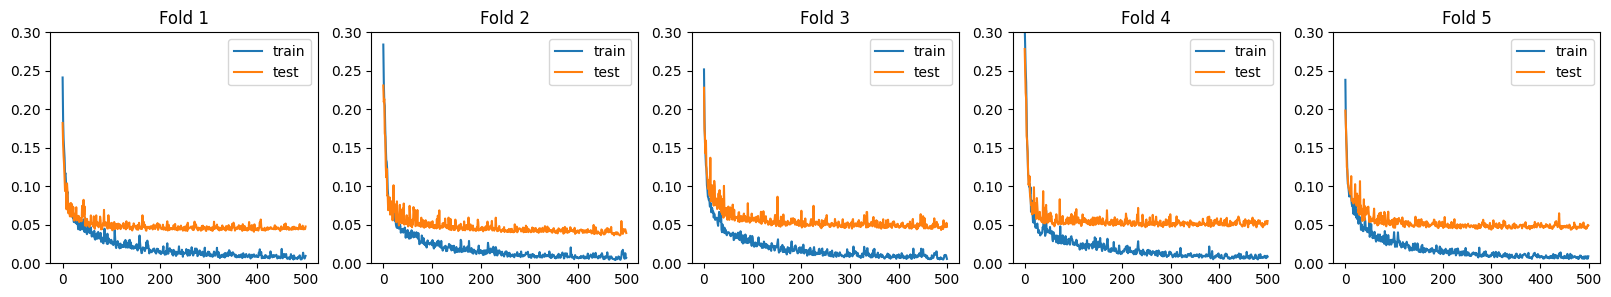

In [15]:
plt.figure(figsize=(20, 3))

for i in range(len(kf_histories)):
    plt.subplot(1, 5, i+1)
    plt.plot(kf_histories[i].history['loss'], label='train')
    plt.plot(kf_histories[i].history['val_loss'], label='test')
    plt.ylim([0, 0.3])
    plt.title('Fold ' + str(i+1))
    plt.legend()
plt.show()

El error absoluto medio despues de la validación cruzada es de aproximadamente 1 dB. Existen algunos folds donde hay mas sobreajuste que en otros, afectando el rendimiento promedio de la estimación.

## V. Validación cruzada con regularización

In [17]:
kf = KFold(n_splits=5, shuffle=True)
kf_scores = []
kf_histories = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ch_train, ch_test = ch[train_index], ch[test_index]

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    model = create_model(X_train.shape[1], y_train.shape[1], extra_feat_dim=ch_train.shape[1], reg=True)
    history = model.fit([X_train, ch_train], y_train, epochs=500, batch_size=16, validation_data=([X_test, ch_test], y_test), verbose=0)

    y_pred = model.predict([X_test, ch_test])
    preds = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_test)

    kf_scores.append(mean_absolute_error(y_true, preds))
    kf_histories.append(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [18]:
print(f'El MAE promedio es: {np.mean(kf_scores):.4f} dB')

El MAE promedio es: 1.5297 dB


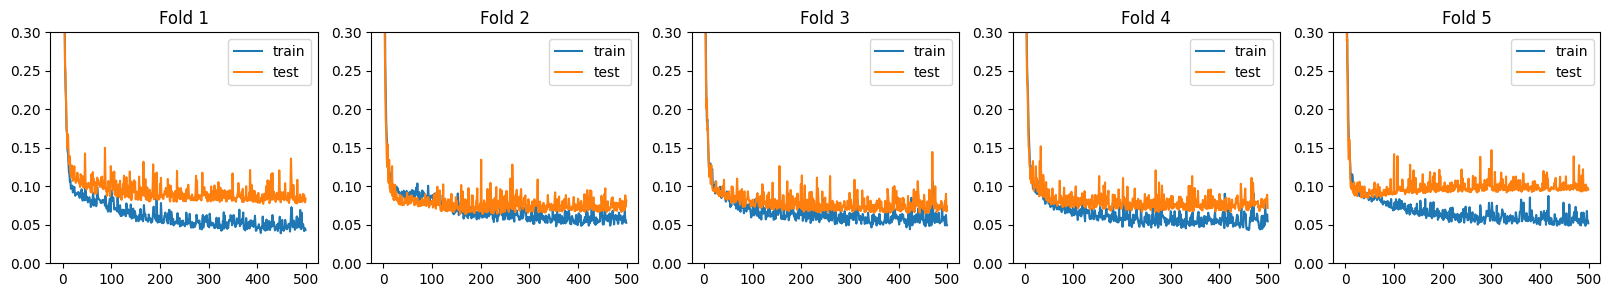

In [19]:
plt.figure(figsize=(20, 3))

for i in range(len(kf_histories)):
    plt.subplot(1, 5, i+1)
    plt.plot(kf_histories[i].history['loss'], label='train')
    plt.plot(kf_histories[i].history['val_loss'], label='test')
    plt.ylim([0, 0.3])
    plt.title('Fold ' + str(i+1))
    plt.legend()
plt.show()

Al incluir dos capas ocultas con regularización L2, se nta que el rendimiento promedio despues de la validación cruzada redujo un poco, siendo de aproximadamente 1.5 dB. Sin embargo, las curvas de error, en este caso, muestran un menor sobreajuste, lo que hace la predicción más confiable.